# 패키지

In [1]:
import os                           # 운영체제
import time                         # 시간
import tensorflow as tf             # 텐서플로
import tensorflow_addons as tfa     # 텐서플로 에드온
import pandas as pd                 # 판다스
import matplotlib.pyplot as plt     # 그래프 도구
import MSRL                         # Musical Symbol Recognition Library

c:\Users\chorokmoo_win\.conda\envs\new\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# GPU 설정

In [2]:
# 사용 가능한 모든 GPU 리스트
gpus = tf.config.list_physical_devices('GPU')

# 사용할 프로세서 선택 : GPU
if gpus:
    try: tf.config.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e: print(e)

# 학습 준비

In [3]:
# 데이터셋
msDataset = MSRL.datasets.MusicalSymbolDataset()

# 모델
msModel = MSRL.models.MusicalSymbolModel()

# 모델 Object Detection

In [4]:
# 모델 주소
model_OD_dir = os.path.join('.', 'models', 'model_OD.h5')
model_OD_epoch_dir = os.path.join('.', 'models', 'model_OD-{epoch}.h5')
tensorboard_OD_dir = os.path.join('.', 'model_TB', 'model_OD', time.strftime("%Y_%m_%d-%H_%M_%S"))

# 모델 콜백 함수
cb_checkpoint_OD = tf.keras.callbacks.ModelCheckpoint(model_OD_epoch_dir, monitor='loss', save_best_only=True)
cb_early_stop_OD = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=False)
cb_tensorboard_OD = tf.keras.callbacks.TensorBoard(tensorboard_OD_dir)

# 데이터셋 준비
ds_OD_train, ds_OD_validation, ds_OD_test = msDataset.ds_OD()

-- TFDS Train ------------------
input  0 : (20000,), <dtype: 'string'>
output 0  : (20000, 60), <dtype: 'int16'>
output 1  : (20000, 10), <dtype: 'int16'>
---------------------------------
total number of labels : 20000
number of each class : [20000, 20000, 12199, 9861, 11111, 7495, 9717, 12162, 10582, 11722]

-- TFDS Validation ------------------
input  0 : (400,), <dtype: 'string'>
output 0  : (400, 60), <dtype: 'int16'>
output 1  : (400, 10), <dtype: 'int16'>
---------------------------------
total number of labels : 400
number of each class : [400, 400, 243, 187, 218, 150, 204, 240, 217, 234]

-- TFDS Test ------------------
input  0 : (400,), <dtype: 'string'>
output 0  : (400, 60), <dtype: 'int16'>
output 1  : (400, 10), <dtype: 'int16'>
---------------------------------
total number of labels : 400
number of each class : [400, 400, 238, 201, 222, 156, 200, 255, 222, 238]



In [5]:
# 그래프 초기화
tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    # 모델 존재 확인
    if os.path.exists(model_OD_dir): model_OD = tf.keras.models.load_model(model_OD_dir) # 모델 불러오기
    else:                            model_OD = msModel.model_OD() # 모델 생성

    # 모델 컴파일 설정
    model_OD.compile(
        optimizer='adam',
        loss=[
            MSRL.losses.WeightedIoU(20000, [20000, 20000, 12199, 9861, 11111, 7495, 9717, 12162, 10582, 11722]),
            MSRL.losses.WeightedBC(20000, [20000, 20000, 12199, 9861, 11111, 7495, 9717, 12162, 10582, 11722])
        ],
        metrics=[
            # 모델 출력 1
            [MSRL.metrics.IoU()],           # IoU 점수 평균
            # 모델 출력 2
            [MSRL.metrics.Accuracy(),       # 정확도
             MSRL.metrics.HammingScore(),]  # 해밍 점수
        ]
    )

    # 모델 훈련
    history_OD = model_OD.fit(
        ds_OD_train,
        epochs=20,
        initial_epoch=0,
        validation_data=ds_OD_validation,
        callbacks=[cb_checkpoint_OD, cb_early_stop_OD, cb_tensorboard_OD]
    )

    # 현재까지 학습된 모델 저장
    model_OD.save(model_OD_dir)

# 텐서보드 확인
# tensorboard.exe --logdir=.\model_TB\model_OD --port=6006

Epoch 1/20
625/625 [==============================] - 230s 303ms/step - loss: nan - tf.reshape_1_loss: nan - out2_loss: nan - tf.reshape_1_IoU: nan - out2_Accuracy: 0.0000e+00 - out2_HammingScore: 8.2500e-04 - val_loss: nan - val_tf.reshape_1_loss: nan - val_out2_loss: nan - val_tf.reshape_1_IoU: nan - val_out2_Accuracy: 0.0000e+00 - val_out2_HammingScore: 0.0000e+00
Epoch 2/20
625/625 [==============================] - 187s 300ms/step - loss: nan - tf.reshape_1_loss: nan - out2_loss: nan - tf.reshape_1_IoU: nan - out2_Accuracy: 0.0000e+00 - out2_HammingScore: 0.0000e+00 - val_loss: nan - val_tf.reshape_1_loss: nan - val_out2_loss: nan - val_tf.reshape_1_IoU: nan - val_out2_Accuracy: 0.0000e+00 - val_out2_HammingScore: 0.0000e+00
Epoch 3/20
436/625 [===================>..........] - ETA: 56s - loss: nan - tf.reshape_1_loss: nan - out2_loss: nan - tf.reshape_1_IoU: nan - out2_Accuracy: 0.0000e+00 - out2_HammingScore: 0.0000e+00

# 학습 결과

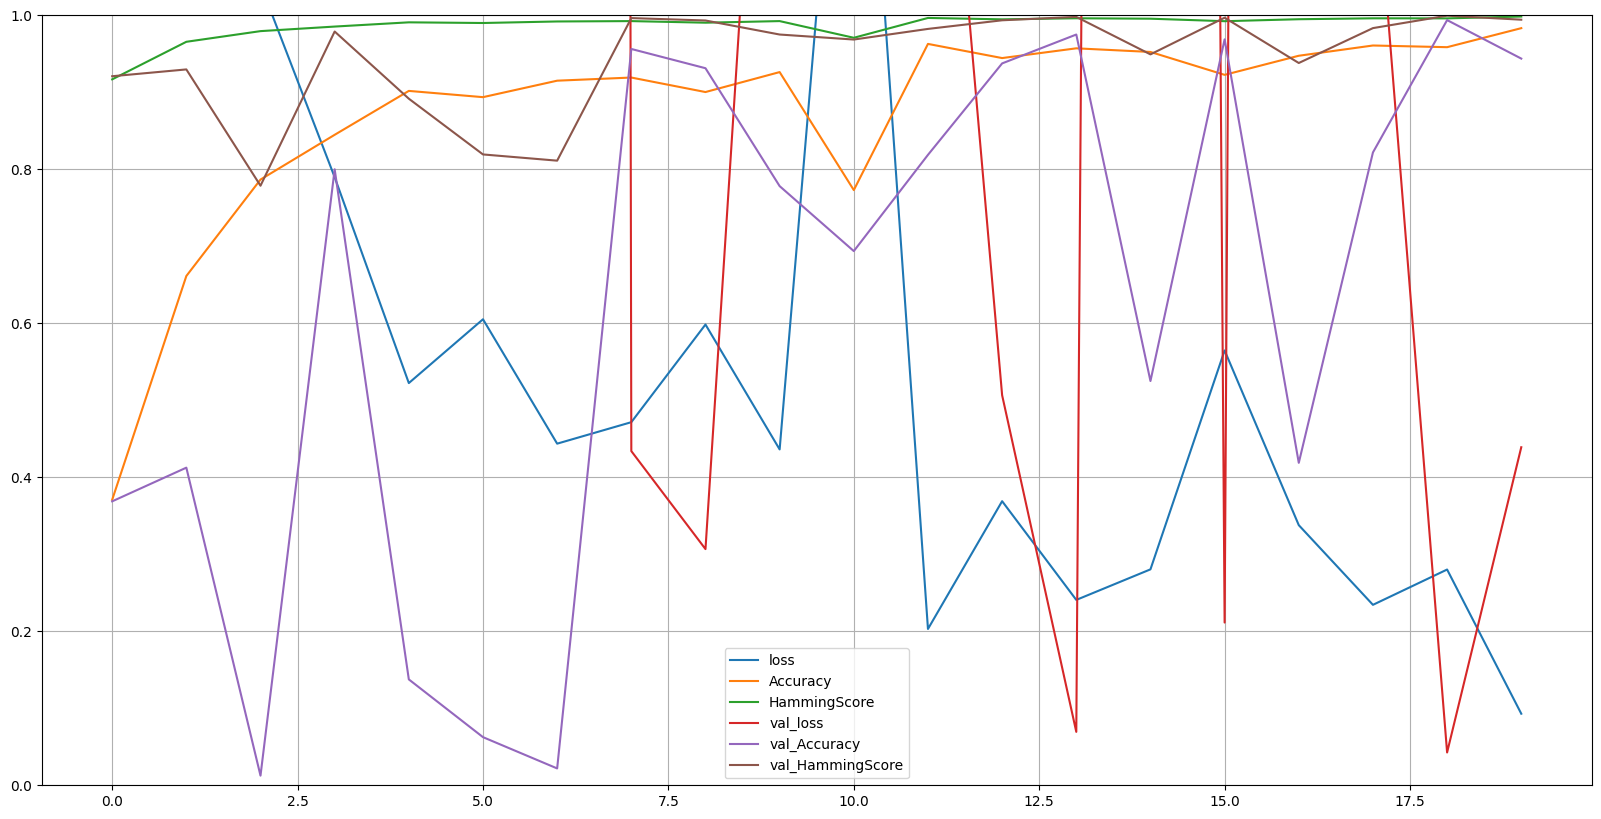

In [6]:
# model_YOLO 훈련 결과 그리기
pd.DataFrame(history_OD.history).plot(figsize=(20, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()